<center><h1><b>A/B Testing</b></h1></center>
                            

![Alt Text](https://upload.wikimedia.org/wikipedia/commons/2/2e/A-B_testing_example.png)


###### Image source - Wikepedia



**A/B tests are hypothesis tests that help us compare two different versions of the same thing to test whether the latest version has any improved performance.**  

**This code demonstration is to check if a change in the marketing strategy of a website improved in website's performance in terms of reaching the audience and converting them to valuable users.**

**In this example, we first do some basic analysis through EDA on the different features of the data and then create necessary features, and then perform some statistical tests to validate our hypothesis to see if there are any differences made by the new marketing Campaign.**    
**Then we will validate the results to extract the helpful insights and then conclude based on our learnings.**

## Loading required libraries and data

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tabulate import tabulate


In [2]:

control = pd.read_csv("/kaggle/input/ab-testing-dataset/control_group.csv",delimiter=";")
test = pd.read_csv("/kaggle/input/ab-testing-dataset/test_group.csv",delimiter=";")

In [3]:
control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


## Cleaning and processing the data

In [5]:
# Checking for NULL values

control.isna().sum()

Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64

We can fill the null values with previous days result. Here we are assuming the results remained same to the previous day where the records are empty.

In [6]:
control = control.fillna(method="bfill")

/tmp/ipykernel_17/1607740924.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  control = control.fillna(method="bfill")


In [7]:
test.isna().sum()

Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       0
Reach                  0
# of Website Clicks    0
# of Searches          0
# of View Content      0
# of Add to Cart       0
# of Purchase          0
dtype: int64

In [8]:
#
## Renaming the column names for the convience


new_names = ['Campaign Name', 'Date', 'Spend', 'Impressions', 'Reach',
       'Website Clicks', 'Searches', 'View Content',
       'Add to Cart', 'Purchase']
control_columns = [x + "_control" if x!="Date" else x for x in new_names ]

columns_map = dict(zip(control.columns,control_columns))

control = control.rename(columns=columns_map)

In [9]:
new_names = ['Campaign Name', 'Date', 'Spend', 'Impressions', 'Reach',
       'Website Clicks', 'Searches', 'View Content',
       'Add to Cart', 'Purchase']
test_columns = [x + "_test" if x!="Date" else x for x in new_names ]

columns_map_test = dict(zip(test.columns,test_columns))

test = test.rename(columns=columns_map_test)

In [10]:
## Merging both control and test datasets into one dataframe

df = control.merge(test,how="inner",on="Date")

## EDA

### Impressions

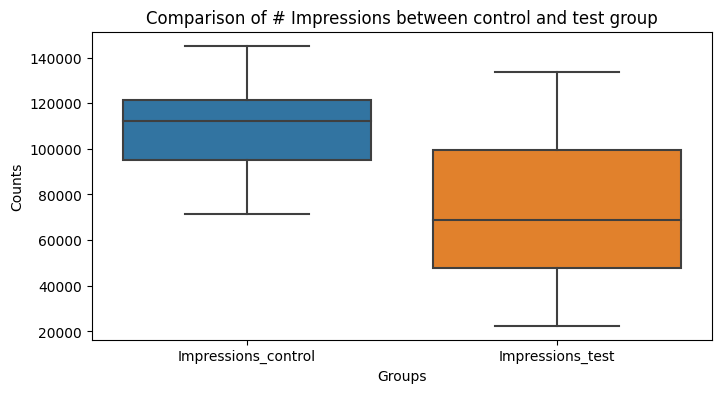

+---------------------+---------+-----------+----------+----------+----------+-----------+-----------+-----------+
|                     |   count |      mean |      std |      min |      25% |       50% |       75% |       max |
+=====================+=========+===========+==========+==========+==========+===========+===========+===========+
| Impressions_control |   30.00 | 109543.63 | 21311.88 | 71274.00 | 95191.25 | 112368.00 | 121259.00 | 145248.00 |
+---------------------+---------+-----------+----------+----------+----------+-----------+-----------+-----------+
| Impressions_test    |   30.00 |  74584.80 | 32121.38 | 22521.00 | 47541.25 |  68853.50 |  99500.00 | 133771.00 |
+---------------------+---------+-----------+----------+----------+----------+-----------+-----------+-----------+


In [11]:
df_melted = df[["Impressions_control","Impressions_test"]].melt(var_name='Group', value_name='Values')

plt.figure(figsize=(8, 4))
sns.boxplot(x='Group', y='Values', data=df_melted)

plt.title('Comparison of # Impressions between control and test group')
plt.ylabel('Counts')
plt.xlabel('Groups')
plt.show()
summary = df[["Impressions_control","Impressions_test"]].describe().T
print(tabulate(summary, headers='keys', floatfmt=".2f", tablefmt="grid"))


### Spend

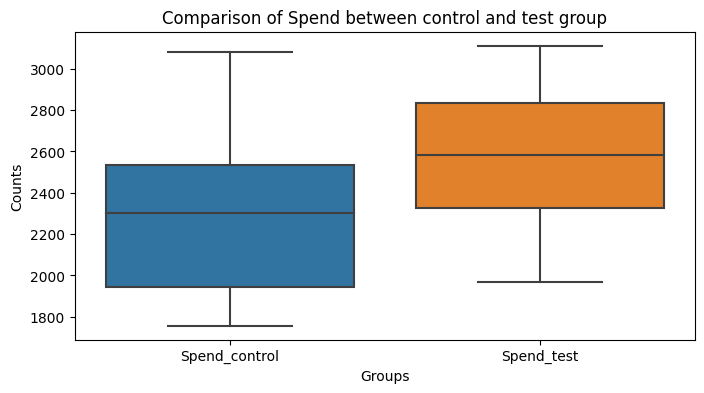

+---------------+---------+---------+--------+---------+---------+---------+---------+---------+
|               |   count |    mean |    std |     min |     25% |     50% |     75% |     max |
+===============+=========+=========+========+=========+=========+=========+=========+=========+
| Spend_control |   30.00 | 2288.43 | 367.33 | 1757.00 | 1945.50 | 2299.50 | 2532.00 | 3083.00 |
+---------------+---------+---------+--------+---------+---------+---------+---------+---------+
| Spend_test    |   30.00 | 2563.07 | 348.69 | 1968.00 | 2324.50 | 2584.00 | 2836.25 | 3112.00 |
+---------------+---------+---------+--------+---------+---------+---------+---------+---------+


In [12]:
df_melted = df[["Spend_control","Spend_test"]].melt(var_name='Group', value_name='Values')

plt.figure(figsize=(8, 4))
sns.boxplot(x='Group', y='Values', data=df_melted)

plt.title('Comparison of Spend between control and test group')
plt.ylabel('Counts')
plt.xlabel('Groups')
plt.show()
summary = df[["Spend_control","Spend_test"]].describe().T
print(tabulate(summary, headers='keys', floatfmt=".2f", tablefmt="grid"))


### Reach

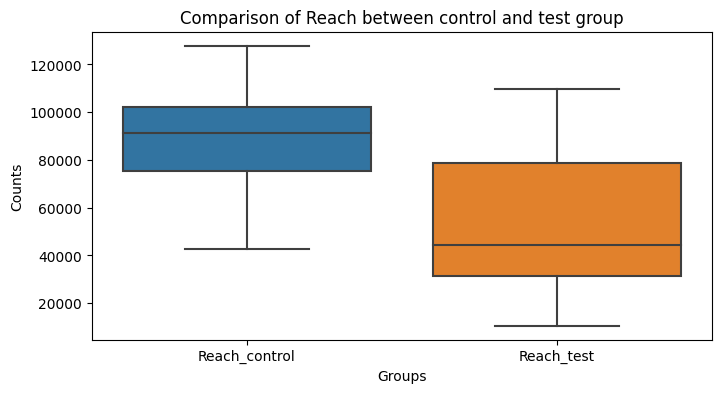

+---------------+---------+----------+----------+----------+----------+----------+-----------+-----------+
|               |   count |     mean |      std |      min |      25% |      50% |       75% |       max |
+===============+=========+==========+==========+==========+==========+==========+===========+===========+
| Reach_control |   30.00 | 88816.70 | 21453.18 | 42859.00 | 75300.25 | 91418.00 | 101958.75 | 127852.00 |
+---------------+---------+----------+----------+----------+----------+----------+-----------+-----------+
| Reach_test    |   30.00 | 53491.57 | 28795.78 | 10598.00 | 31516.25 | 44219.50 |  78778.75 | 109834.00 |
+---------------+---------+----------+----------+----------+----------+----------+-----------+-----------+


In [13]:
df_melted = df[["Reach_control","Reach_test"]].melt(var_name='Group', value_name='Values')

plt.figure(figsize=(8, 4))
sns.boxplot(x='Group', y='Values', data=df_melted)

plt.title('Comparison of Reach between control and test group')
plt.ylabel('Counts')
plt.xlabel('Groups')
plt.show()
summary = df[["Reach_control","Reach_test"]].describe().T
print(tabulate(summary, headers='keys', floatfmt=".2f", tablefmt="grid"))


### Purchase

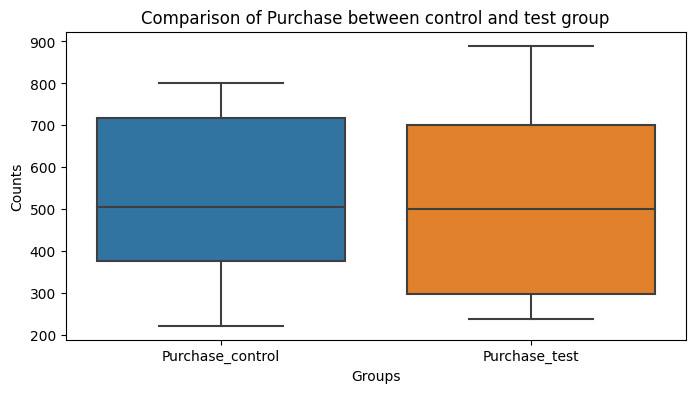

+------------------+---------+--------+--------+--------+--------+--------+--------+--------+
|                  |   count |   mean |    std |    min |    25% |    50% |    75% |    max |
+==================+=========+========+========+========+========+========+========+========+
| Purchase_control |   30.00 | 530.83 | 187.07 | 222.00 | 375.50 | 506.00 | 718.00 | 800.00 |
+------------------+---------+--------+--------+--------+--------+--------+--------+--------+
| Purchase_test    |   30.00 | 521.23 | 211.05 | 238.00 | 298.00 | 500.00 | 701.00 | 890.00 |
+------------------+---------+--------+--------+--------+--------+--------+--------+--------+


In [14]:
df_melted = df[["Purchase_control","Purchase_test"]].melt(var_name='Group', value_name='Values')

plt.figure(figsize=(8, 4))
sns.boxplot(x='Group', y='Values', data=df_melted)

plt.title('Comparison of Purchase between control and test group')
plt.ylabel('Counts')
plt.xlabel('Groups')
plt.show()
summary = df[["Purchase_control","Purchase_test"]].describe().T
print(tabulate(summary, headers='keys', floatfmt=".2f", tablefmt="grid"))


By looking at above plots, it seems that the spend is more for test group which tells us more money spent on test campaign.

The total impression is lesser than the control which says the new test marketing ad has appeared very less number of times compared to older ad.

As the total impression is comparitively lesser , we can expect other metrics like reach, and # of clicks to be relatively less for the test.

But, in the last the number of purchases looks almost similar between test and control. Which signifies even the scale of ads run was comapretively less it seems to be effective than control group.

So lets see if these changes are statistically significant by running some tests. 
But again looking at these existing features may not give us the better results. So we can derive some generalized features which can be compared through statistical tests.

## Feature creation

To continue with the tests we will create these below features and will see if there any significant differences in these.

#### **Cost per Mille (CPM)**  
**Definition**: The cost to generate 1,000 impressions from your marketing campaign.  
**Usage**: Commonly used in display advertising, this metric shows the cost efficiency of generating visibility for your ads.

$$\text{CPM} = \left( \frac{\text{Total Spend}}{\text{Impressions}} \right) \times 1000$$  


#### **Click-Through Rate (CTR)**  
**Definition**: Measures how many users clicked on your website link after seeing it (based on impressions).  
**Usage**: Indicates how effective your ad or content is at driving traffic to the website.

$$\text{CTR} = \left( \frac{\text{Website Clicks}}{\text{Impressions}} \right) \times 100$$



#### **Cost per Click (CPC)**
**Definition**: Measures the cost of each click generated by your marketing spend.  
**Usage**: Helps determine how cost-efficient your campaigns are at generating clicks.

$$\text{CPC} = \frac{\text{Total Spend}}{\text{Website Clicks}}$$

#### **Conversion Rate**
**Definition**: The percentage of visitors who take a desired action, such as making a purchase after clicking on the website.  
**Usage**: Helps assess how well your site converts visitors into customers.  

$$\text{Conversion Rate} = \left( \frac{\text{Purchases}}{\text{Website Clicks}} \right) \times 100$$


#### **Reach-to-Click Rate**
**Definition**: The percentage of unique users (reach) who clicked on the website link.    
**Usage**: Indicates how well your content converts reach into website traffic.  

$$\text{Reach-to-Click Rate} = \left( \frac{\text{Website Clicks}}{\text{Reach}} \right) \times 100$$


#### **Content Viewed-to-Add-to-Cart Rate**
**Definition**: The percentage of users who added an item to the cart after viewing product content.      
**Usage**:  Shows how engaging and persuasive your product content is in getting users to consider a purchase.  

$$\text{Content-to-Cart Rate} = \left( \frac{\text{Add to Cart Number}}{\text{Content Viewed}} \right) \times 100$$


#### **Cart Abandonment Rate**
**Definition**: The percentage of users who added items to their cart but didn’t complete the purchase.     
**Usage**:  Helps identify friction in the checkout process or hesitations in the customer journey.  

$$\text{Cart Abandonment Rate} = \left( \frac{\text{Add to Cart Number} - \text{Purchases}}{\text{Add to Cart Number}} \right) \times 100$$



#### **Purchase Rate (Impressions to Purchases)**
**Definition**: The percentage of users who made a purchase after seeing the content or ad.    
**Usage**:  This metric helps measure the overall success of your impressions at driving actual sales.  

$$\text{Purchase Rate (Impressions)} = \left( \frac{\text{Purchases}}{\text{Impressions}} \right) \times 100$$


#### **Purchase Rate (Content Viewed to Purchase)**
**Definition**: The percentage of users who made a purchase after viewing product content.     
**Usage**:  Indicates how well product pages convert content viewers into paying customers.  

$$\text{Content-to-Purchase Rate} = \left( \frac{\text{Purchases}}{\text{Content Viewed}} \right) \times 100$$



        



In [15]:
# Cost per Mille (CPM)

df['Cost per Mille (CPM)_control'] = np.divide(df['Spend_control'],df['Impressions_control'])* 1000
df['Cost per Mille (CPM)_test']  = np.divide(df['Spend_test'],df['Impressions_test']) * 1000

# Click-Through Rate (CTR)

df['Click-Through Rate (CTR)_control'] = np.divide(df['Website Clicks_control'],df['Impressions_control'])* 100
df['Click-Through Rate (CTR)_test'] = np.divide(df['Website Clicks_test'],df['Impressions_test']) * 100

# Cost per Click (CPC)

df['Cost per Click (CPC)_control'] = np.divide(df['Spend_control'],df['Website Clicks_control'])
df['Cost per Click (CPC)_test'] = np.divide(df['Spend_test'],df['Website Clicks_test'])

# Conversion Rate

df['Conversion Rate_control'] = np.divide(df['Purchase_control'],df['Website Clicks_control'])*100
df['Conversion Rate_test'] = np.divide(df['Purchase_test'],df['Website Clicks_test'])*100


# Reach-to-Click Rate

df['Reach-to-Click Rate_control'] = np.divide(df['Website Clicks_control'],df['Reach_control']) * 100
df['Reach-to-Click Rate_test'] = np.divide(df['Website Clicks_test'],df['Reach_test']) * 100


# Content Viewed-to-Add-to-Cart Rate

df['Content Viewed-to-Add-to-Cart Rate_control'] = np.divide(df['Add to Cart_control'],df['View Content_control']) * 100
df['Content Viewed-to-Add-to-Cart Rate_test'] = np.divide(df['Add to Cart_test'],df['View Content_test']) * 100


# Cart Abandonment Rate

df['Cart Abandonment Rate_control'] = np.divide((df['Add to Cart_control'] - df['Purchase_control']),df['Add to Cart_control']) * 100
df['Cart Abandonment Rate_test'] = np.divide((df['Add to Cart_test'] - df['Purchase_test']),df['Add to Cart_test']) * 100


# Purchase Rate (Impressions to Purchases) 

df['Purchase Rate (Impressions to Purchases)_control']  = np.divide(df['Purchase_control'],df['Impressions_control']) * 100
df['Purchase Rate (Impressions to Purchases)_test']  = np.divide(df['Purchase_test'],df['Impressions_test']) * 100


# Purchase Rate (Content Viewed to Purchase)

df['Purchase Rate (Content Viewed to Purchase)_control'] = np.divide(df['Purchase_control'],df['View Content_control']) * 100
df['Purchase Rate (Content Viewed to Purchase)_test'] = np.divide(df['Purchase_test'],df['View Content_test']) * 100


## Hypothesis Tests

In [16]:
features = ["Cost per Mille (CPM)","Click-Through Rate (CTR)","Cost per Click (CPC)","Conversion Rate","Reach-to-Click Rate",
           "Content Viewed-to-Add-to-Cart Rate","Cart Abandonment Rate","Purchase Rate (Impressions to Purchases)",
            "Purchase Rate (Content Viewed to Purchase)"]

#### **Deciding the tests**


So we can first decide which hypothesis test suits each feature better. We can decide by the following approach
1. If the data is normally distributed and follows **equality of variance** then we can perform **Independent T test**.
2. If the data is normally distributed and **does not follow equality of variance**, we can run **Welch's t-test**.
3. If the data is not normally distributed then we can go with the **Mann-Whitney U test**

*Equality of variance (also known as homogeneity of variance or homoscedasticity) refers to the assumption that different groups in your dataset have the same variance. This means that the spread or variability of the data points within each group is approximately the same*  

We can run **Shapiro-Wilk test** to check if the features are normally distributed or not.  
We will be using **Levene's Test** to check the Equality of variances.


So our hypothesis is going to be the following :

**H0/Null Hypothesis** - There is no statistically significant changes between control and test group.  
**H1/Alternate Hypothesis** - There is some statistically significant changes between control and test group




In [17]:
## Checking normality by Shapiro test
#
# Also creating a dataframe "results_df" with all the features and corresponding values of tests and results
#
#


results_df = pd.DataFrame()
results_df['Features'] = features

test_statistics = []
p_values = []
results = []

# Looping for all the features and running Shapiro to each of the feature and saving the different results in different lists
for feature in features:

    col = feature+"_test"
    statistic,p_value = stats.shapiro(df[col])
    test_statistics.append(statistic)
    p_values.append(p_value)    
    # print(f'Feature : {col} , Statistic: {statistic}, P-value: {p_value}')

    if p_value<0.05:
        results.append("Mann-Whitney U test")
    else:
        results.append("Ind T test")


# Adding the results into the Global dataframe "results_df", its correspoding features rest resilts 

results_df['Shapiro_statistics'] = test_statistics
results_df['Shapiro_p_value'] = p_values
results_df['Hypothesis Test'] = results



In [18]:
print(tabulate(results_df, headers='keys', floatfmt=".4f",tablefmt="grid"))


+----+--------------------------------------------+----------------------+-------------------+---------------------+
|    | Features                                   |   Shapiro_statistics |   Shapiro_p_value | Hypothesis Test     |
+====+============================================+======================+===================+=====================+
|  0 | Cost per Mille (CPM)                       |               0.8486 |            0.0006 | Mann-Whitney U test |
+----+--------------------------------------------+----------------------+-------------------+---------------------+
|  1 | Click-Through Rate (CTR)                   |               0.8409 |            0.0004 | Mann-Whitney U test |
+----+--------------------------------------------+----------------------+-------------------+---------------------+
|  2 | Cost per Click (CPC)                       |               0.9114 |            0.0162 | Mann-Whitney U test |
+----+--------------------------------------------+-------------

In [19]:
## Running Levenes Tets for checking equality of variance
#
# Also adding the results of the tests into a different dataframe
#


t_test_features = list(results_df.loc[results_df['Hypothesis Test']=="Ind T test",'Features'].values)

levenes_results = pd.DataFrame()
levenes_results['Features'] = t_test_features

test_statistics2 = []
p_values2 = []
results2 = []

for feat in t_test_features:
    test_col = feat + "_test"
    conttrol_col = feat + "_control"

    
    statistic,p_value = stats.levene(df[test_col],df[conttrol_col])
    test_statistics2.append(statistic)
    p_values2.append(p_value)
    
    # print(f'Feature : {feat} , Statistic: {statistic}, P-value: {p_value}')

    if p_value<0.05:
        results2.append("Welch's T test")
    else:
        results2.append("Ind T test")


levenes_results['Levene_statistics'] = test_statistics2
levenes_results['Levene_P-value'] = p_values2
levenes_results['Hypothesis Tests New'] = results2

print(tabulate(levenes_results, headers='keys', floatfmt=".4f",tablefmt="grid"))


## Merging the Levene's tests results into the Global features dataframe.

results_df = results_df.merge(levenes_results[['Features','Hypothesis Tests New']],on='Features',how='left')

+----+------------------------------------+---------------------+------------------+------------------------+
|    | Features                           |   Levene_statistics |   Levene_P-value | Hypothesis Tests New   |
+====+====================================+=====================+==================+========================+
|  0 | Content Viewed-to-Add-to-Cart Rate |              2.9999 |           0.0886 | Ind T test             |
+----+------------------------------------+---------------------+------------------+------------------------+
|  1 | Cart Abandonment Rate              |              2.3760 |           0.1286 | Ind T test             |
+----+------------------------------------+---------------------+------------------+------------------------+


**Updating the Hypothesis tests**

In [20]:
### Updating the Hypothesis tests after the Levene;s test and retaining only required columns 

results_df['Hypothesis Test'] = np.where(results_df['Hypothesis Tests New'].isna(),results_df['Hypothesis Test'],results_df['Hypothesis Tests New'])

results_df = results_df[['Features','Hypothesis Test']]

print(tabulate(results_df, headers='keys', floatfmt=".4f",tablefmt="grid"))


+----+--------------------------------------------+---------------------+
|    | Features                                   | Hypothesis Test     |
+====+============================================+=====================+
|  0 | Cost per Mille (CPM)                       | Mann-Whitney U test |
+----+--------------------------------------------+---------------------+
|  1 | Click-Through Rate (CTR)                   | Mann-Whitney U test |
+----+--------------------------------------------+---------------------+
|  2 | Cost per Click (CPC)                       | Mann-Whitney U test |
+----+--------------------------------------------+---------------------+
|  3 | Conversion Rate                            | Mann-Whitney U test |
+----+--------------------------------------------+---------------------+
|  4 | Reach-to-Click Rate                        | Mann-Whitney U test |
+----+--------------------------------------------+---------------------+
|  5 | Content Viewed-to-Add-to-Cart R

In [21]:
#
# Defining a program to run the corresponding hypothesis tests for each of the features
#

def run_test(feature,test):
    
    if test == 'Ind T test':
        statistic,p_value = stats.ttest_ind(df[feature+"_control"],df[feature+"_test"])
    elif test == 'Mann-Whitney U test':
        statistic,p_value = stats.mannwhitneyu(df[feature+"_control"],df[feature+"_test"],alternative='two-sided')
    elif test == "Welch's T test":
        statistic,p_value = stats.ttest_ind(df[feature+"_control"],df[feature+"_test"],equal_var=False)

    # print("___________________________________________________________________________________________________")

    # print(f'Featue : {feature} ,Statistic: {statistic}, P-value: {p_value}')
    if p_value>0.05:
        # print(f"There is no statistically significant differences in the feature {feature}")
        return statistic,p_value,False
    else:
        # print(f"There is statistically significant differences in the feature {feature}")
        return statistic,p_value,True   


In [22]:
#
#
# Running the corresponding hypothesis tests to each features and adding all the test results into the Global results dataframe
#
#
statistics = []
p_values = []
result_result = []

for ind,row in results_df.iterrows():
    result = run_test(row['Features'],row['Hypothesis Test'])
    statistics.append(result[0])
    p_values.append(result[1])
    result_result.append(result[2])


## Updating all the test results into Global dataframe

results_df['Test Statistics'] = statistics
results_df['p value'] = p_values
results_df['Difference exists'] = result_result


In [23]:
print(tabulate(results_df, headers='keys', floatfmt=".4f",tablefmt="grid"))


+----+--------------------------------------------+---------------------+-------------------+-----------+---------------------+
|    | Features                                   | Hypothesis Test     |   Test Statistics |   p value | Difference exists   |
+====+============================================+=====================+===================+===========+=====================+
|  0 | Cost per Mille (CPM)                       | Mann-Whitney U test |          115.0000 |    0.0000 | True                |
+----+--------------------------------------------+---------------------+-------------------+-----------+---------------------+
|  1 | Click-Through Rate (CTR)                   | Mann-Whitney U test |          195.0000 |    0.0002 | True                |
+----+--------------------------------------------+---------------------+-------------------+-----------+---------------------+
|  2 | Cost per Click (CPC)                       | Mann-Whitney U test |          468.0000 |    0.7958 

**We can see for total of 6 metrics there is some statistically significant difference exists.**

**(But this does not mean the test campaign made some positive differences only in its effectiveness. The differences may be even worsening in any of these metrics.**  
**So we should inspect each of these metrics and compared aginst both group to derive the final conclusion.**



## Validation of Test results

In [24]:
#
## Calculating median of each feature in from both control and test group, for comparing....
#

results_df['control_median'] = results_df['Features'].apply(lambda x:df[x+"_control"].median())
results_df['test_median'] = results_df['Features'].apply(lambda x:df[x+"_test"].median())



In [25]:
print(tabulate(results_df.loc[results_df['Difference exists']==True,['Features', 'Hypothesis Test','Difference exists', 'control_median', 'test_median']], headers='keys', floatfmt=".4f",tablefmt="grid"))


+----+------------------------------------------+---------------------+---------------------+------------------+---------------+
|    | Features                                 | Hypothesis Test     | Difference exists   |   control_median |   test_median |
+====+==========================================+=====================+=====================+==================+===============+
|  0 | Cost per Mille (CPM)                     | Mann-Whitney U test | True                |          20.8804 |       34.1016 |
+----+------------------------------------------+---------------------+---------------------+------------------+---------------+
|  1 | Click-Through Rate (CTR)                 | Mann-Whitney U test | True                |           4.5792 |        8.0359 |
+----+------------------------------------------+---------------------+---------------------+------------------+---------------+
|  4 | Reach-to-Click Rate                      | Mann-Whitney U test | True                |    

**It seems there is reduction happened for metrics like "Content Viewed-to-Add-to-Cart Rate" which is bad and for "Cart Abandonment Rate" which is good thing.**  

**Also there are increase in median for rest of the 4 metrics including cost per Mille which is not expected but for others it shows improvement.**


**Lets validate these changes visually for these metrics...**

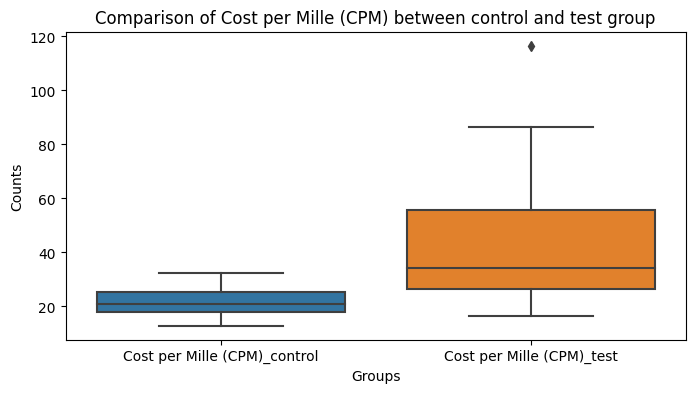

+------------------------------+---------+--------+-------+-------+-------+-------+-------+--------+
|                              |   count |   mean |   std |   min |   25% |   50% |   75% |    max |
+==============================+=========+========+=======+=======+=======+=======+=======+========+
| Cost per Mille (CPM)_control |   30.00 |  21.55 |  4.76 | 12.91 | 17.88 | 20.88 | 25.39 |  32.55 |
+------------------------------+---------+--------+-------+-------+-------+-------+-------+--------+
| Cost per Mille (CPM)_test    |   30.00 |  42.68 | 23.75 | 16.45 | 26.28 | 34.10 | 55.67 | 116.60 |
+------------------------------+---------+--------+-------+-------+-------+-------+-------+--------+

_______________________________________________________________________________________________



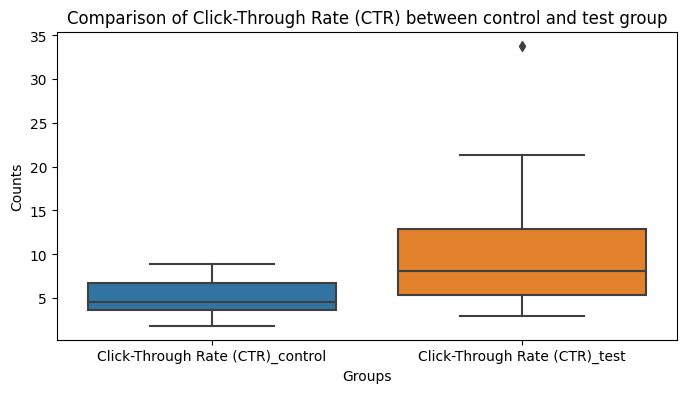

+----------------------------------+---------+--------+-------+-------+-------+-------+-------+-------+
|                                  |   count |   mean |   std |   min |   25% |   50% |   75% |   max |
+==================================+=========+========+=======+=======+=======+=======+=======+=======+
| Click-Through Rate (CTR)_control |   30.00 |   5.05 |  2.03 |  1.86 |  3.64 |  4.58 |  6.70 |  8.83 |
+----------------------------------+---------+--------+-------+-------+-------+-------+-------+-------+
| Click-Through Rate (CTR)_test    |   30.00 |  10.24 |  6.77 |  2.98 |  5.31 |  8.04 | 12.85 | 33.82 |
+----------------------------------+---------+--------+-------+-------+-------+-------+-------+-------+

_______________________________________________________________________________________________



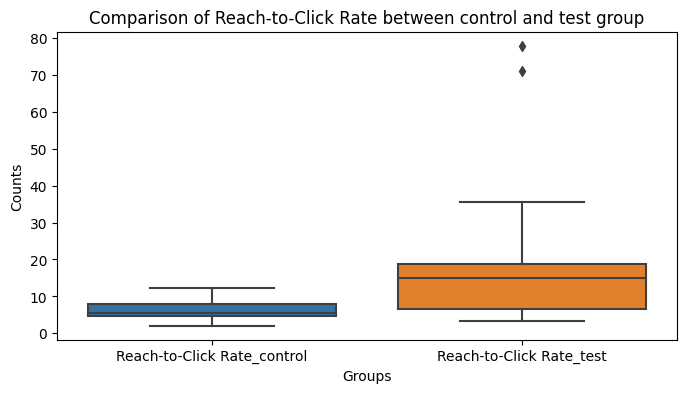

+-----------------------------+---------+--------+-------+-------+-------+-------+-------+-------+
|                             |   count |   mean |   std |   min |   25% |   50% |   75% |   max |
+=============================+=========+========+=======+=======+=======+=======+=======+=======+
| Reach-to-Click Rate_control |   30.00 |   6.39 |  2.86 |  2.06 |  4.56 |  5.46 |  7.93 | 12.32 |
+-----------------------------+---------+--------+-------+-------+-------+-------+-------+-------+
| Reach-to-Click Rate_test    |   30.00 |  17.41 | 17.30 |  3.39 |  6.66 | 14.91 | 18.65 | 77.98 |
+-----------------------------+---------+--------+-------+-------+-------+-------+-------+-------+

_______________________________________________________________________________________________



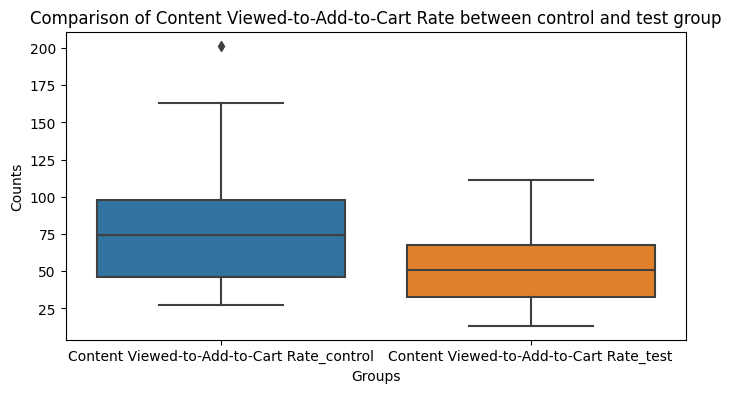

+--------------------------------------------+---------+--------+-------+-------+-------+-------+-------+--------+
|                                            |   count |   mean |   std |   min |   25% |   50% |   75% |    max |
+============================================+=========+========+=======+=======+=======+=======+=======+========+
| Content Viewed-to-Add-to-Cart Rate_control |   30.00 |  77.28 | 40.52 | 27.41 | 45.83 | 73.98 | 97.51 | 201.53 |
+--------------------------------------------+---------+--------+-------+-------+-------+-------+-------+--------+
| Content Viewed-to-Add-to-Cart Rate_test    |   30.00 |  51.51 | 24.50 | 13.47 | 32.61 | 50.85 | 67.71 | 111.42 |
+--------------------------------------------+---------+--------+-------+-------+-------+-------+-------+--------+

_______________________________________________________________________________________________



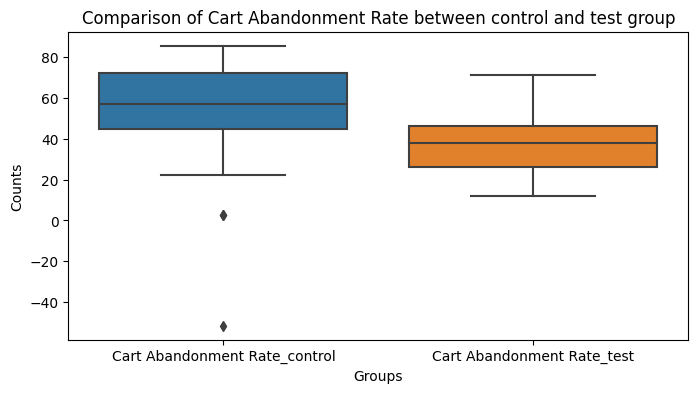

+-------------------------------+---------+--------+-------+--------+-------+-------+-------+-------+
|                               |   count |   mean |   std |    min |   25% |   50% |   75% |   max |
+===============================+=========+========+=======+========+=======+=======+=======+=======+
| Cart Abandonment Rate_control |   30.00 |  52.56 | 28.72 | -51.58 | 44.92 | 57.25 | 72.45 | 85.66 |
+-------------------------------+---------+--------+-------+--------+-------+-------+-------+-------+
| Cart Abandonment Rate_test    |   30.00 |  38.21 | 15.15 |  11.87 | 26.00 | 37.86 | 46.41 | 71.48 |
+-------------------------------+---------+--------+-------+--------+-------+-------+-------+-------+

_______________________________________________________________________________________________



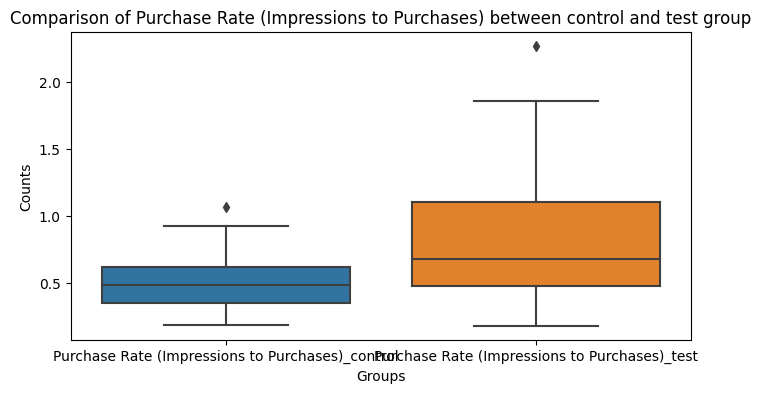

+--------------------------------------------------+---------+--------+-------+-------+-------+-------+-------+-------+
|                                                  |   count |   mean |   std |   min |   25% |   50% |   75% |   max |
+==================================================+=========+========+=======+=======+=======+=======+=======+=======+
| Purchase Rate (Impressions to Purchases)_control |   30.00 |   0.51 |  0.22 |  0.19 |  0.35 |  0.48 |  0.62 |  1.07 |
+--------------------------------------------------+---------+--------+-------+-------+-------+-------+-------+-------+
| Purchase Rate (Impressions to Purchases)_test    |   30.00 |   0.84 |  0.52 |  0.18 |  0.48 |  0.68 |  1.11 |  2.27 |
+--------------------------------------------------+---------+--------+-------+-------+-------+-------+-------+-------+

_______________________________________________________________________________________________



In [26]:
#
#
# Looping through each feature which showed significant differences and then plotting the box plots for each under control and test group for 
# visualizing their distribution
#
#

for feature in results_df.loc[results_df['Difference exists']==True,'Features']:

    df_melted = df[[feature+"_control",feature+"_test"]].melt(var_name='Group', value_name='Values')
    
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Group', y='Values', data=df_melted)
    
    plt.title(f'Comparison of {feature} between control and test group')
    plt.ylabel('Counts')
    plt.xlabel('Groups')
    plt.show()
    summary = df[[feature+"_control",feature+"_test"]].describe().T
    print(tabulate(summary, headers='keys', floatfmt=".2f", tablefmt="grid"))
    print()
    print("_______________________________________________________________________________________________")
    print()


## **Conclusion**


1. **Cost Effectiveness**  
    The Cost per Mille which is cost incurred to get 1000 impression is more in Test campaign, but Cost per click has seen no much significant difference between Control and Test.**  
    So we can say the test campaign is slightly costlier in terms of getting more impressions.

2. **Campaign Effectiveness**  
    **The click through rate** has significant improvement in test campaign so it is able to convert impressions into click more effectively than     before.  
    Same goes for **Reach to click ratio**, where more unique users are visiting the site by clicking which is very good improvement in test campaign.  
    Whereas **content-viewed-to-add-to-cart-ratio** has comparitively reduced, so the any changes in contents page may not be working out well here.  
    **Cart-abandonment-rate** has comparitvely reduced which is very good improved. It says when customers are adding some products to the cart they  are more liekely making purchanses than before.    
    **Purchase rate** also improved (from impression to purchase), so users which are looking at the add are more liekly to make a purchase in the test       campaign than before.
   

   
   





**So even though the cost in increased in test campaign it proved to be effective when looked at other metrics**